In [18]:
import numpy as np
from tqdm import tqdm
from utils import sample_partition
from utils import CheckStatus, check_solution
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.special import stirling2
from utils import set_partitions

In [36]:
def ba(
    work: np.ndarray[float],
    time: np.ndarray[float],
    cost: np.ndarray[float],
    effi: np.ndarray[float],
    max_iter: int = 100,
    sol_size: int = 100,
    top_frac: float = 0.2,
    top_attempts: int = 20,
    rest_attempts: int = 10,
    penalty_c: float = 100.0,
    plot: bool = False
) -> tuple[float, list[list[int]]]:
    """Returns an asiigment of workers to tasks that minimizes the cost function.
    Parameter `max_iter` is the number of maximum iterations after which algorithm stops
    `sol_size` is the maximum size of list of solutions at any iteration of algorithm
    `top_frac` is the percentage of solutions that are considered superior
    `top_attempts` is the number of bees assigned to to superior solutions
    `rest attempts` is the number of bees that are assigned to inferior solutions
    `penalty_c` is a parameter that is used to compute the final cost of solution 
    than penalizes incorrect solutions"""

    assert all(isinstance(arr, np.ndarray) for arr in (work, time, cost, effi)), "Expected Numpy arrays"
    assert all(len(arr.shape) == 1 for arr in (work, time, cost, effi)), "Expected 1-D arrays"
    assert work.shape == time.shape, "Expected `work` and `time` arrays to have the same shape"
    assert cost.shape == effi.shape, "Expected `cost` and `effi` arrays to have the same shape"
    assert (n_jobs := len(work)) <= (n_workers := len(cost)), "Expected n_workers >= n_jobs"

    def encode(partition: list[list[int]]) -> list[int]:
        """Encodes the solution represented as a list of lists where each i-th list contains workers
        assigned to i-th job into a list of `n_workers` values where each value is an int between 0
        and `n_jobs - 1` which determines the job assigned to a given worker.
        """
        encoding = [None for _ in range(n_workers)]
        for i, job in enumerate(partition):
            for worker in job:
                encoding[worker] = i
        return encoding

    def decode(solution: list[int]) -> list[list[int]]:
        """Decodes the solution represented as a list of `n_workers` values where each value is an
        int between 0 and `n_jobs - 1` which determines the job assigned to a given worker into a
        list of lists where each i-th list contains workers assigned to i-th job.
        """
        partition = [[] for _ in range(n_jobs)]
        for worker, job in enumerate(solution):
            partition[job].append(worker)
        return partition

    def objective(solution: list[int]) -> float:
        """Computes the value of the objective function for the given solution solution defined as
        the negated value of the cost function for the defined above combinatorial optimization
        problem.
        """
        partition = decode(solution)
        return -sum(w * cost[p].sum() / effi[p].sum() for w, p in zip(work, partition))

    def penalty(solution: list[int]) -> float:
        """Computes the penalty for the given solution solution if it violates the 'max time to
        finish given job'-constraint. The penalty is computed as a sum of differences between the
        time it takes to finish the job and max allowed time for this job (if the time is smaller
        the summand is 0). This sum is then multiplied by a suitably chosen penalty coefficient.
        """
        partition = decode(solution)
        return penalty_c * sum(max(0, w / effi[p].sum() - t) for w, t, p in zip(work, time, partition))

    def alter(solution: list[int], p: float = 0.5) -> list[int]:
        """Returns random permutation of given list `solution`. This permutation is computed by
        switching tasks of randomly chosen workers. Parameter `p` is the probability that two
        randomly chosen workers switch their tasks."""

        _solution = solution.copy()

        if np.random.random() < p:
            i, j = np.random.choice(n_workers, size=2, replace=False)
            _solution[i], _solution[j] = _solution[j], _solution[i]
        else:
            _solution[np.random.randint(n_workers)] = np.random.randint(n_jobs)

            while len(unassigned := (set(range(n_jobs)) - set(_solution))) != 0:
                for job in unassigned:
                    _solution[np.random.randint(n_workers)] = job

        return _solution

    fitness = lambda solution: objective(solution) - penalty(solution)
    best_fitness, best_assignment = -float("inf"), None

    # Sample initial solutions, encode them as linear arrays and sort according do fitness values
    solutions = [sample_partition(n_workers, n_jobs) for _ in tqdm(range(sol_size), desc="Sampling...")]
    solutions = [encode(partition) for partition in solutions]
    solutions = sorted(solutions, key=fitness, reverse=True)
    if plot == True:
        best, average = [], []
    # NOTE: Is this really the whole algorithm ???
    for _ in (pbar := tqdm(range(max_iter))):
        # Update the best assignment and fitness value found so far
        if (best_iter_fitness := fitness(solutions[0])) > best_fitness:
            best_fitness, best_assignment = best_iter_fitness, solutions[0]

        # Update progress bar
        pbar.set_description(desc=f"Best fitness: {best_fitness:.3f}")

        new_solutions = []
        for i, sol in enumerate(solutions):
            for _ in range(top_attempts if i < top_frac * sol_size else rest_attempts):
                new_solutions.append(alter(sol))

        solutions = sorted(solutions + new_solutions, key=fitness, reverse=True)[:sol_size]
        if plot:
            best.append(fitness(solutions[0]))
            average.append(sum(fitness(i) for i in solutions) / len(solutions))
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(15,10))
        ax[0].plot([i for i in range(max_iter)], best)
        ax[0].set_title("best fit function value in iteration")
        ax[0].set_xlabel("iteration")
        ax[0].set_ylabel("fitness of best solution")
        ax[1].plot([i for i in range(max_iter)], average)
        ax[1].set_title("average fit function value in iteration")
        ax[1].set_xlabel("iteration")
        ax[1].set_ylabel("fitness of average solution")
        fig.savefig("ba_fitness_function1.png")
        plt.show()
    return -best_fitness, decode(best_assignment)

In [10]:
def get_data(NT: int, NM: int):
    work = np.random.random(NT)
    time = np.random.random(NT)
    cost = np.random.random(NM)
    effi = np.random.random(NM)
    return work, time, cost, effi

Best fitness: -1.238: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.25it/s]


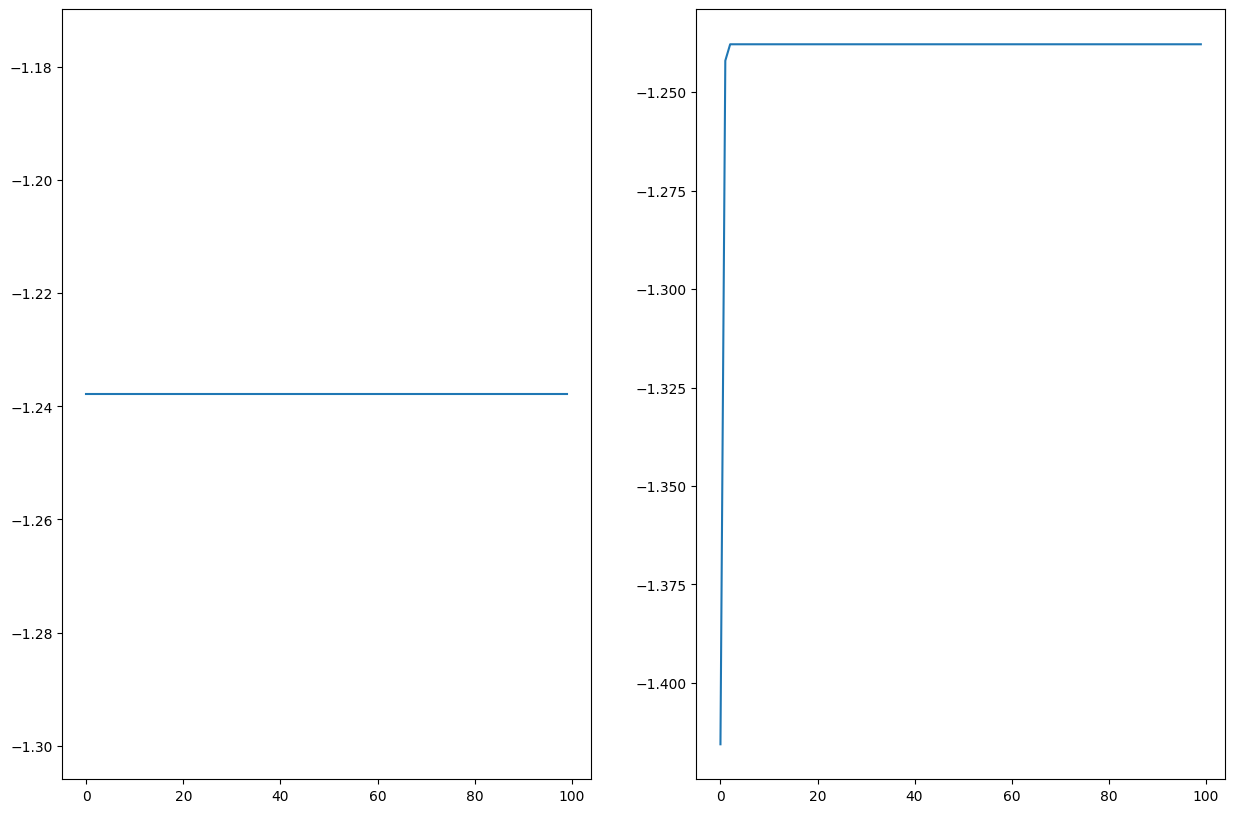

Solution found!
Best cost = 1.238
Best assignment = [[3], [1, 4], [0, 2]]


In [11]:
work = np.array([0.0564, 0.5310, 0.8676])
time = np.array([0.5367, 0.4316, 0.9047])
cost = np.array([0.4241, 0.7391, 0.3058, 0.6060, 0.6486])
effi = np.array([0.5549, 0.3572, 0.7561, 0.1787, 0.9503])
best_cost, best_assignment = ba(work, time, cost, effi, plot=True)

if CheckStatus.Correct != (status_code := check_solution(best_assignment, best_cost, work, time, cost, effi)):
    print(f"Solution incorrect: {status_code}")
else:
    print("\n".join(["Solution found!", f"Best cost = {best_cost:.3f}", f"Best assignment = {best_assignment}"]))


Best fitness: -11.009: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.64it/s]


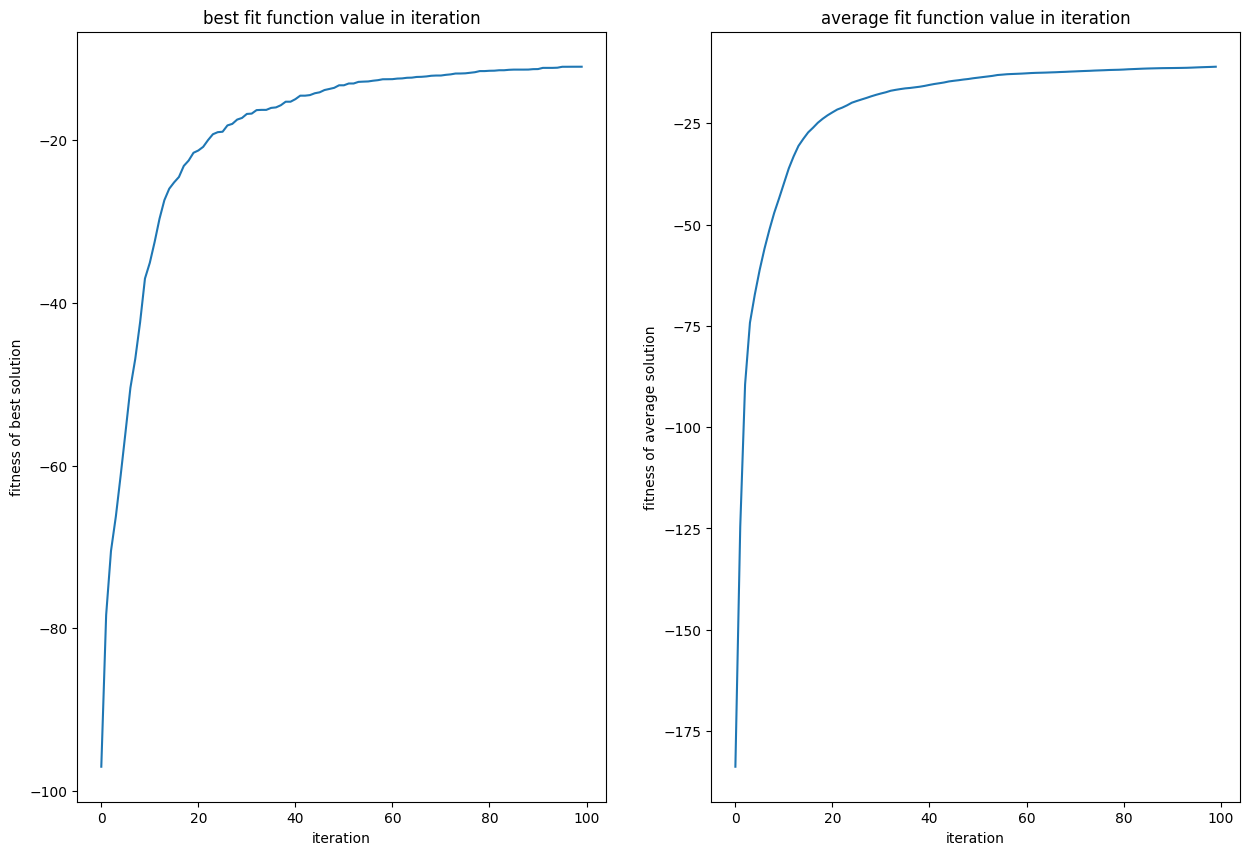

Solution incorrect: [TimeExceeded] At least one job takes more time than available.


Best fitness: -96.748: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.37it/s]


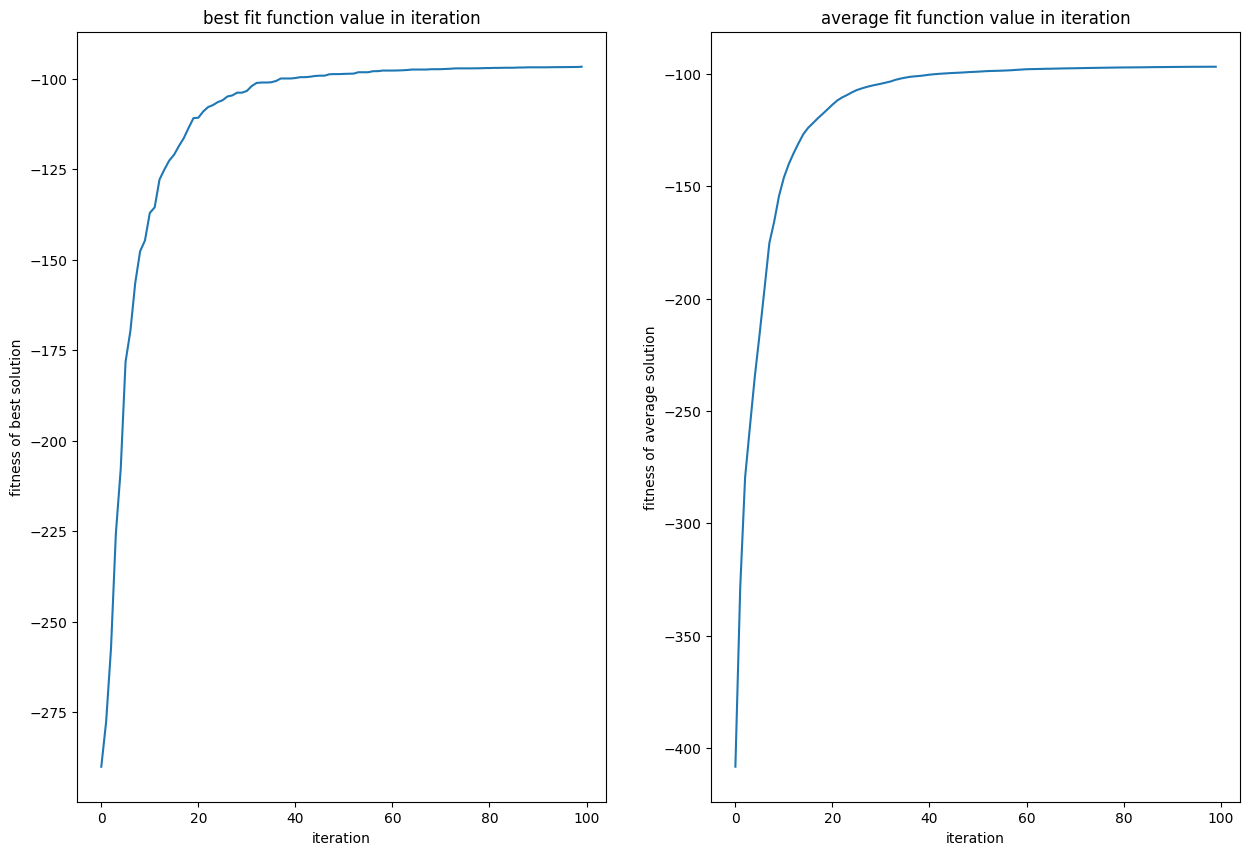

Solution incorrect: [TimeExceeded] At least one job takes more time than available.


Best fitness: -159.953: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.45it/s]


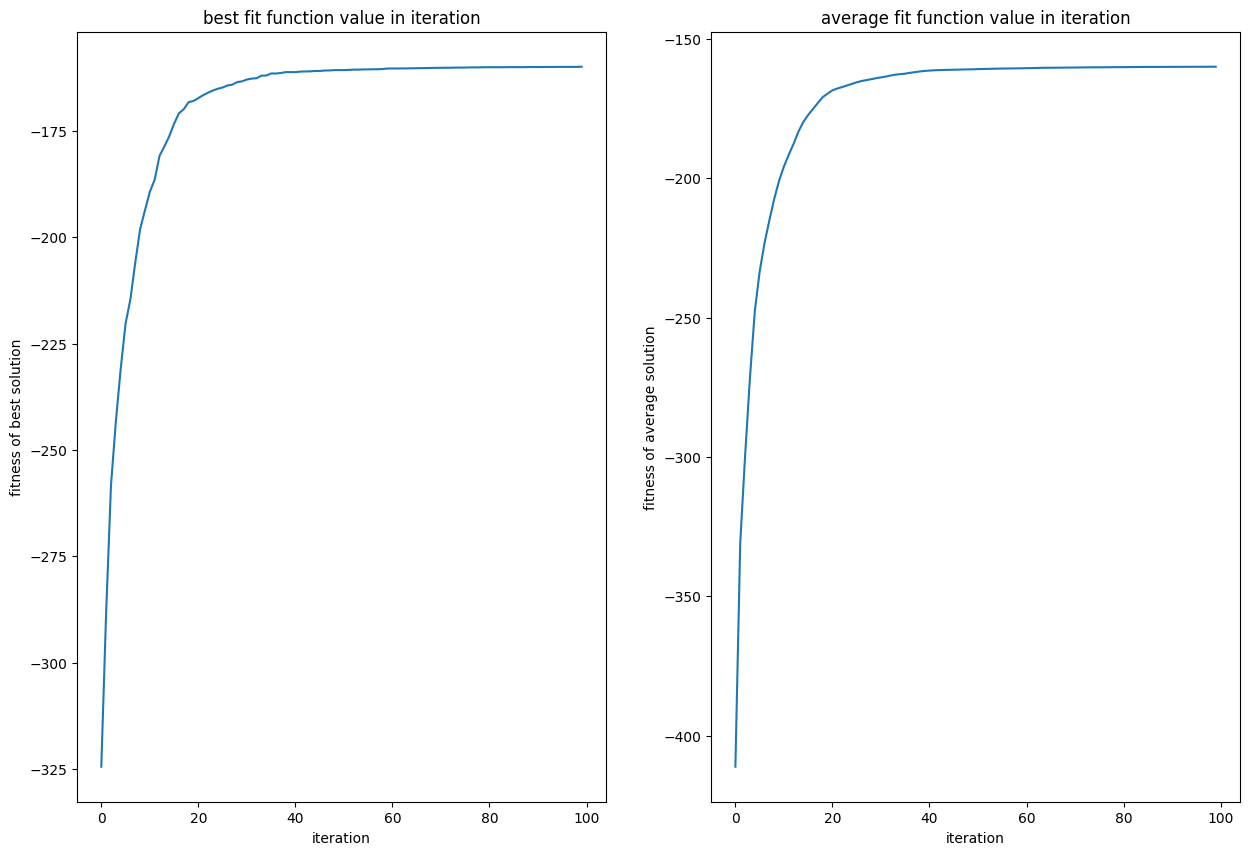

Solution incorrect: [TimeExceeded] At least one job takes more time than available.


Best fitness: -16.135: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.44it/s]


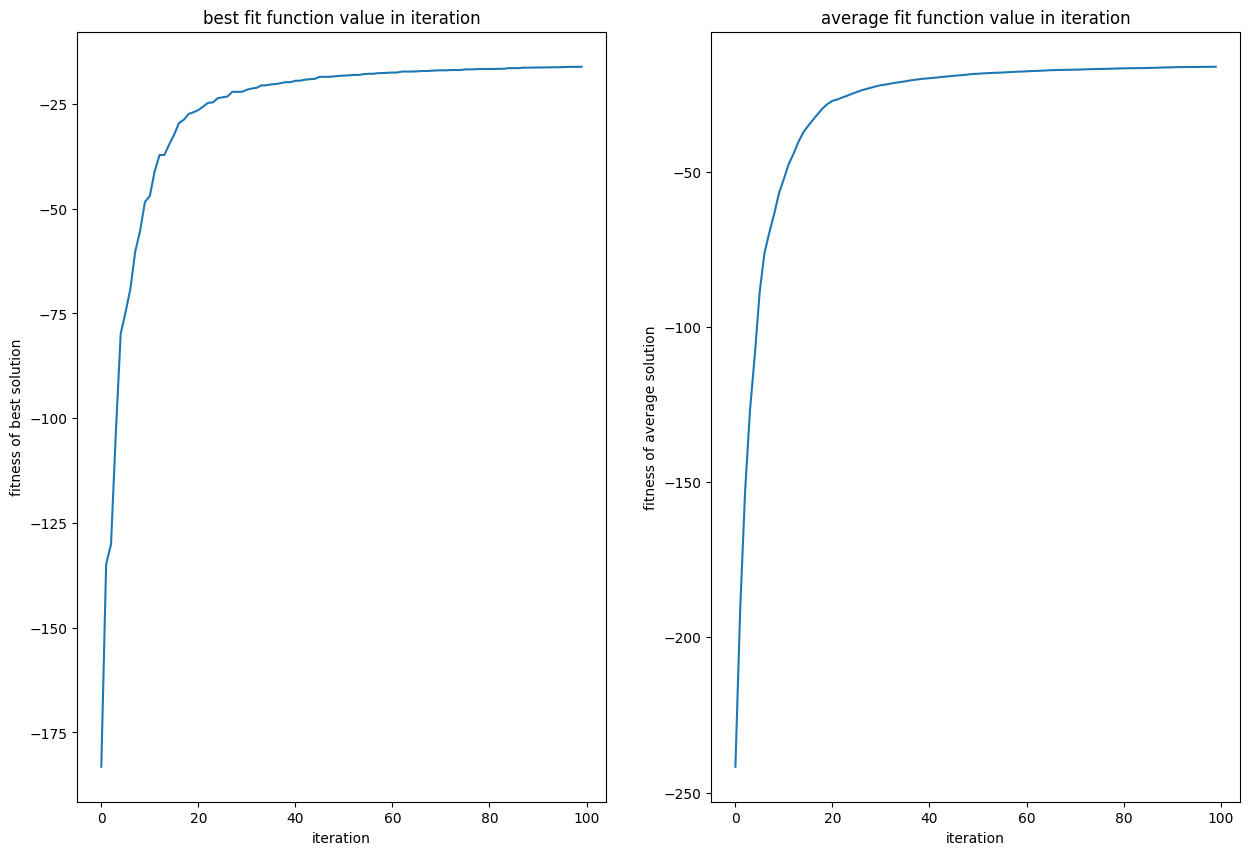

Solution incorrect: [TimeExceeded] At least one job takes more time than available.


Best fitness: -3.787: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.45it/s]


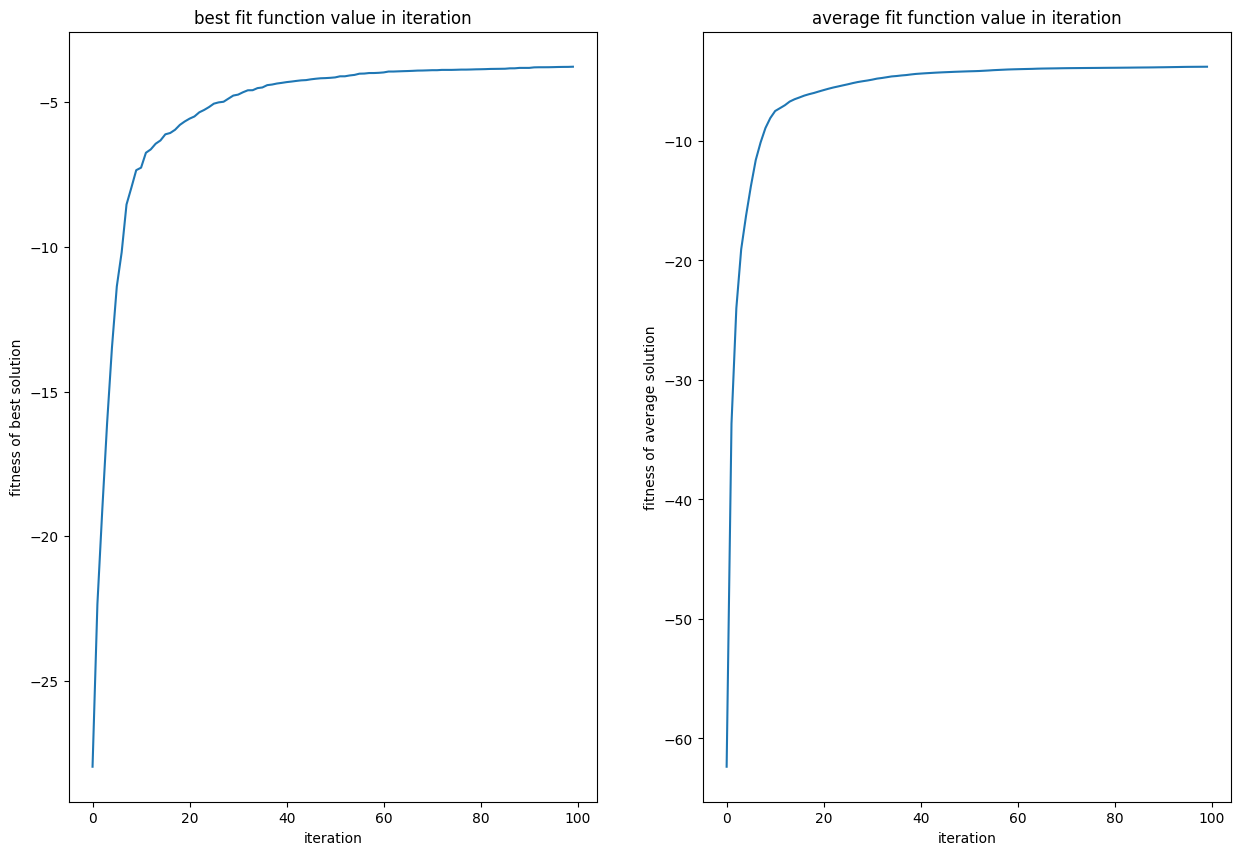

In [37]:

while True:
    work, time, cost, effi = get_data(20, 60)
    best_cost, best_assignment = ba(work, time, cost, effi, plot=True)

    if CheckStatus.Correct != (status_code := check_solution(best_assignment, best_cost, work, time, cost, effi)):
        print(f"Solution incorrect: {status_code}")
    else:
        break
        print("\n".join(["Solution found!", f"Best cost = {best_cost:.3f}", f"Best assignment = {best_assignment}"]))


In [38]:
for name, array in zip(("work", "time", "cost", "effi"),(work, time, cost, effi)):
    print(name,": [",", ".join([str(a) for a in array]),"]")

work : [ 0.41423818278724756, 0.10899201119361535, 0.4806647643435987, 0.7685332272123908, 0.3464875047373782, 0.4609214189979487, 0.982926713621583, 0.8434463264130726, 0.16281687096869712, 0.18971232618133527, 0.7210918721555004, 0.5514323367071218, 0.3362225239303226, 0.7670036321772804, 0.536951512396537, 0.06297897390473006, 0.05836369361834903, 0.8692970487473838, 0.8005810012204424, 0.057642167580022274 ]
time : [ 0.3952485693974829, 0.8061435142377815, 0.7343519927825163, 0.6100361168201692, 0.6131105389408111, 0.9625161608056155, 0.7339859901510395, 0.40209404125065007, 0.15296174642149807, 0.0718255417581195, 0.5984509272273635, 0.814030957937548, 0.14815514634274973, 0.18387639367286157, 0.7443315975338314, 0.18293782622064825, 0.25789889641613384, 0.8192954707221, 0.5990122703820081, 0.5536479626473787 ]
cost : [ 0.22704432765196136, 0.6994738215815396, 0.8088723293774639, 0.2070542324449699, 0.28517296427292005, 0.4935583375409355, 0.17687396432971625, 0.8655317389802316, 

In [39]:

def ga(
    work: np.ndarray[float],
    time: np.ndarray[float],
    cost: np.ndarray[float],
    effi: np.ndarray[float],
    max_iter: int = 100,
    pop_size: int = 100,
    rep_ratio: float = 0.1,
    penalty_c: float = 100.0,
    plot: bool = False,
) -> tuple[float, list[list[int]]]:
    assert all(isinstance(arr, np.ndarray) for arr in (work, time, cost, effi)), "Expected Numpy arrays"
    assert all(len(arr.shape) == 1 for arr in (work, time, cost, effi)), "Expected 1-D arrays"
    assert work.shape == time.shape, "Expected `work` and `time` arrays to have the same shape"
    assert cost.shape == effi.shape, "Expected `cost` and `effi` arrays to have the same shape"
    assert (n_jobs := len(work)) <= (n_workers := len(cost)), "Expected n_workers >= n_jobs"
    assert rep_ratio < 1, "Expected `rep_ratio` to be smaller than 1"

    def encode(partition: list[list[int]]) -> list[int]:
        """Encodes the solution represented as a list of lists where each i-th list contains workers
        assigned to i-th job into a list of `n_workers` values where each value is an int between 0
        and `n_jobs - 1` which determines the job assigned to a given worker.
        """
        encoding = [None for _ in range(n_workers)]
        for i, job in enumerate(partition):
            for worker in job:
                encoding[worker] = i
        return encoding

    def decode(candidate: list[int]) -> list[list[int]]:
        """Decodes the solution represented as a list of `n_workers` values where each value is an
        int between 0 and `n_jobs - 1` which determines the job assigned to a given worker into a
        list of lists where each i-th list contains workers assigned to i-th job.
        """
        partition = [[] for _ in range(n_jobs)]
        for worker, job in enumerate(candidate):
            partition[job].append(worker)
        return partition

    def objective(candidate: list[int]) -> float:
        """Computes the value of the objective function for the given candidate solution defined as
        the negated value of the cost function for the defined above combinatorial optimization
        problem.
        """
        partition = decode(candidate)
        return -sum(w * cost[p].sum() / effi[p].sum() for w, p in zip(work, partition))

    def penalty(candidate: list[int]) -> float:
        """Computes the penalty for the given candidate solution if it violates the 'max time to
        finish given job'-constraint. The penalty is computed as a sum of differences between the
        time it takes to finish the job and max allowed time for this job (if the time is smaller
        the summand is 0). This sum is then multiplied by a suitably chosen penalty coefficient.
        """
        partition = decode(candidate)
        return penalty_c * sum(max(0, w / effi[p].sum() - t) for w, t, p in zip(work, time, partition))

    def cross(parent_x: list[int], parent_y: list[int]) -> list[int]:
        """Implements simple one-point cross-over operator followed by a random resolution of
        'at least one worker for every job'-constraint violations.
        """
        crosspoint = np.random.randint(n_workers)
        child = parent_x[:crosspoint] + parent_y[crosspoint:]

        while len(unassigned := (set(range(n_jobs)) - set(child))) != 0:
            for job in unassigned:
                child[np.random.randint(n_workers)] = job

        return child

    def mutate(candidate: list[int]) -> list[int]:
        """Implements simple mutation operator which swaps two random unique elements of the
        candidate solution.
        """
        i, j = np.random.choice(n_workers, size=2, replace=False)
        _candidate = candidate.copy()
        _candidate[i], _candidate[j] = _candidate[j], _candidate[i]
        return _candidate

    best_fitness, best_assignment = -float("inf"), None

    # Sample initial population and encode candidates as linear arrays
    population = [sample_partition(n_workers, n_jobs) for _ in tqdm(range(pop_size), desc="Sampling population...")]
    population = [encode(partition) for partition in population]
    if plot == True:
        best, iter_best, average = [], [], [] 
        
    for _ in (pbar := tqdm(range(max_iter))):
        # Compute fitness values for every candidate in population
        fitness = [objective(candidate) - penalty(candidate) for candidate in population]

        # Update the best assignment and fitness value found so far
        best_iter_assignment, best_iter_fitness = population[np.argmax(fitness)], np.max(fitness)
        if best_iter_fitness > best_fitness:
            best_fitness, best_assignment = best_iter_fitness, best_iter_assignment

        # Update progress bar
        pbar.set_description(f"Best fitness: {best_fitness:.3f}")

        # Deterministic Binary Tournament selection
        parents = []
        for _ in range(int(rep_ratio * pop_size)):
            i, j = np.random.choice(pop_size, size=2, replace=False)
            parents.append(i if fitness[i] > fitness[j] else j)

        # Apply cross-over and mutation operators
        children = []
        for _ in range(int(rep_ratio * pop_size)):
            i, j = np.random.choice(parents, size=2, replace=False)
            children.append(mutate(cross(population[i], population[j])))

        # Replace the len(children) worst candidates in population with newly created candidates to
        # maintain constant population size
        for i, child in zip(np.argsort(fitness)[: len(children)].tolist(), children):
            population[i] = child
        if plot:
            best.append(best_fitness)
            iter_best.append(best_iter_fitness)
            average.append(sum(fitness)/len(fitness))
    if plot:
        fig, ax = plt.subplots(1, 3, figsize=(15,10))
        ax[0].plot([i for i in range(max_iter)], best)
        ax[0].set_title("best fit function value until given iteration")
        ax[0].set_xlabel("iteration")
        ax[0].set_ylabel("fitness of best solution")
        ax[1].plot([i for i in range(max_iter)], iter_best)
        ax[1].set_title("best fit function value in given iteration")
        ax[1].set_xlabel("iteration")
        ax[1].set_ylabel("fitness of best solution in iteration")
        ax[2].plot([i for i in range(max_iter)], average)
        ax[2].set_title("average fit function value in given iteration")
        ax[2].set_xlabel("iteration")
        ax[2].set_ylabel("fitness of average solution in iteration")
        fig.savefig("ga_fitness_function1.png")
        plt.show()
    return -best_fitness, decode(best_assignment)

Best fitness: -0.563: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.46it/s]


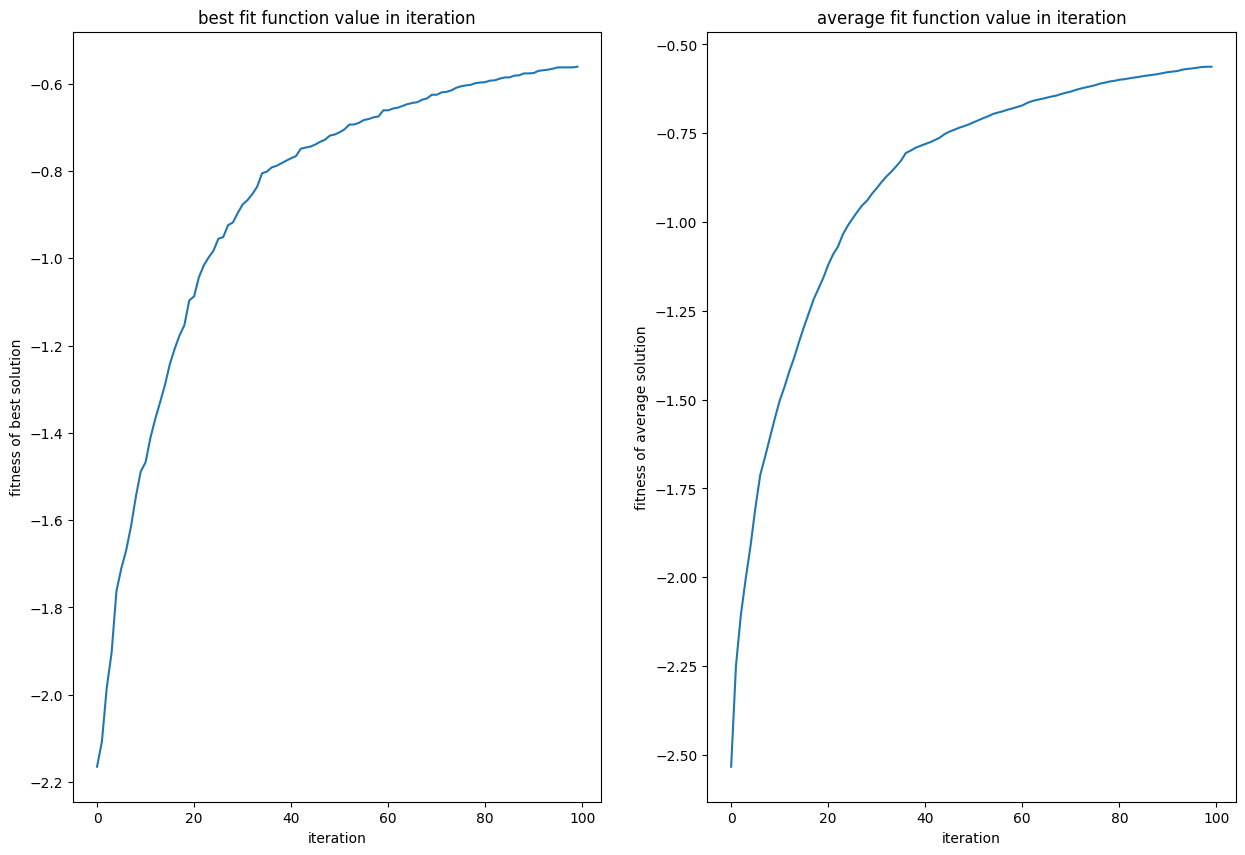

Solution found!
Best cost = 0.563
Best assignment = [[9], [31], [2, 45], [1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 29, 32, 33, 34, 35, 38, 40, 41, 44, 46, 48, 49], [28], [18, 47], [36, 43], [0, 14, 24, 39], [37], [30, 42]]


In [27]:
best_cost, best_assignment = ba(work, time, cost, effi, plot=True)

if CheckStatus.Correct != (status_code := check_solution(best_assignment, best_cost, work, time, cost, effi)):
    print(f"Solution incorrect: {status_code}")
else:
    print("\n".join(["Solution found!", f"Best cost = {best_cost:.3f}", f"Best assignment = {best_assignment}"]))


Best fitness: -7.906: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.15it/s]


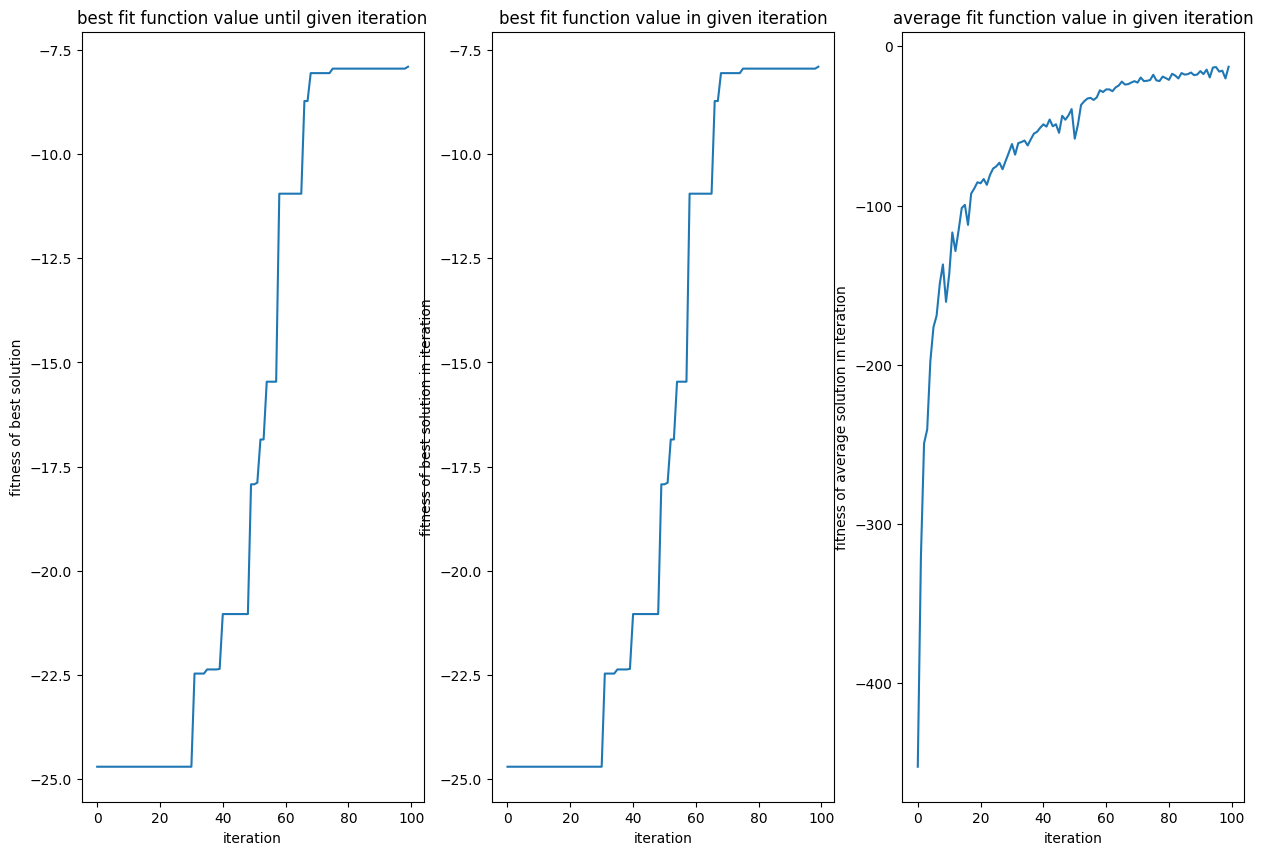

Solution found!
Best cost = 7.906
Best assignment = [[5, 45, 55], [44, 49, 53], [24, 50], [25, 29, 35, 39], [33, 52], [40], [14, 21, 28, 31], [20, 23, 37, 46, 51], [16, 47], [13, 30, 58], [32, 34], [11], [2, 9, 10, 12, 36], [15, 18, 19, 22, 27, 43, 54, 57], [6, 26], [0], [1, 4, 59], [48, 56], [3, 8, 17, 42], [7, 38, 41]]


In [40]:
best_cost, best_assignment = ga(work, time, cost, effi, plot=True)

if CheckStatus.Correct != (status_code := check_solution(best_assignment, best_cost, work, time, cost, effi)):
    print(f"Solution incorrect: {status_code}")
else:
    print("\n".join(["Solution found!", f"Best cost = {best_cost:.3f}", f"Best assignment = {best_assignment}"]))


In [ ]:
b = np.load("positive//test0.npy", allow_pickle=True)

In [ ]:
show_example(b)

In [ ]:
def alter(A, v_swaps: int, h_swaps: int, turn_off: int, turn_on: int):
    """
    h_swaps: number of horizontal swaps
    v_swaps: number of vertical swaps
    turn_off: number of machines to turn off for a random task
    turn on: number of machines to turn on for a random task
    """
    X = deepcopy(A)
    columns_to_swap = zip(
        np.random.randint(0, X.shape[1], v_swaps),
        np.random.randint(0, X.shape[1], v_swaps),
    )
    rows_to_swap = zip(
        np.random.randint(0, X.shape[0], h_swaps),
        np.random.randint(0, X.shape[0], h_swaps),
    )
    for c1, c2 in columns_to_swap:
        tmp = deepcopy(X[:, c1])
        X[:, c1] = X[:, c2]
        X[:, c2] = tmp
    for r1, r2 in rows_to_swap:
        tmp = deepcopy(X[r1, :])
        X[r1, :] = X[r2, :]
        X[r2, :] = tmp
    pairs = list(zip(*np.where(X)))
    chosen = np.random.choice(len(pairs), size=turn_off)
    for ind in chosen:
        X[pairs[ind]] = 0
    return X
    pairs = list(zip(*np.where(X == 0)))
    chosen = np.random.choice(len(pairs), size=turn_on)
    for ind in chosen:
        X[pairs[ind]] = 0
    return X

In [ ]:
rows, cols = gen_solution(NT, NM, NM)
d = coo_matrix((np.ones(NM), (cols, rows)), shape=(NT, NM)).todense()
plt.imshow(d, vmin=0, vmax=1)
plt.show()
new_d = alter(d, 5, 3, 2, 2)
plt.imshow(new_d, vmin=0, vmax=1)
plt.show()
plt.imshow(new_d - d)
plt.show()

In [ ]:
def cost(X, E, D, eta, P, base_only=False):
    cond_1 = np.sum(np.sum(X, axis=0) > 1) ** 2
    cond_2 = np.sum(np.sum(X, axis=1) < 1) ** 2
    cond_3 = E / (np.sum(np.multiply(eta, X), axis=1) + 1e-8) - D  # deadlines not met
    cond_3_sum = np.sum(np.where(cond_3 > 0, 100 * cond_3, 0.1 * cond_3))
    base_cost = np.sum(
        np.multiply(E, np.sum(np.multiply(P, X), axis=1))
        / (np.sum(np.multiply(eta, X), axis=1) + 1e-8)
    )
    if base_only:
        return base_cost
    proper = 4 if (cond_1 or cond_2 or np.any(cond_3 > 0)) else 1
    return (base_cost + cond_3_sum + cond_2 + cond_1) * proper

In [ ]:
cost(X, E, D, eta, P, True)

In [ ]:
distribution = [cost(*get_data(5, 10), base_only=True) for i in range(10000)]
plt.hist(distribution, range=(0, 100), density=True, bins=60)
plt.title("Base cost distribution")
plt.show()

In [ ]:
distribution = [cost(*get_data(10, 50)) for i in range(10000)]
plt.hist(distribution, range=(0, 1e4), density=True, bins=60)
plt.title("Distribution of cost with rules violation penalty")
plt.show()

In [ ]:
_, E, D, eta, P = get_data(NT, NM)

In [ ]:
def get_cheapest_problem(NT: int, NM: int):
    """
    NT - liczba zadań
    NM - liczba maszyn
    """
    problems = []
    for i in range(10000):
        problems.append(get_data(NT, NM))
    return min(problems, key=lambda v: cost(*v))

In [ ]:
def get_random_solutions(
    NT: int,
    NM: int,
    n_solutions: int,
    proper: bool,
    E: np.ndarray,
    D: np.ndarray,
    eta: np.ndarray,
    P: np.ndarray,
):
    """
    NT - liczba zadań
    NM - liczba maszyn
    n_solutions - liczba żądanych rozwiązań
    proper - czy wszystkie zwracane rozwiązania powinny być poprawne
    E, D, eta, P - warunki zadania
    """
    solutions = []
    while len(solutions) < n_solutions:
        rows, cols = gen_solution(NT, NM, NM)
        X = coo_matrix((np.ones(NM), (cols, rows)), shape=(NT, NM)).todense()
        if (not proper) or test_X(X, E, D, eta, P):
            solutions.append(X)
    return solutions

In [ ]:
def bee_algorithm_iteration(
    solutions: list,
    top_n: int,
    top_attempts: int,
    rest_attempts: int,
    max_solutions: int,
    params: dict,
):
    """
    solutions - rozwiązania wejściowe
    top_n - liczba rozwiązań najlepszych - traktowanych priorytetowo
    top_attempts - liczba pszczół dla najlepszych rozwiązań
    rest_attempts - liczba pszczół dla pozostałych rozwiązań
    max_solutions - maksymalna liczba rozwiązań
    params - słownik parametrów określających sposób generowania permutacji rozwiązań
    """
    new_solutions = []
    for i, solution in enumerate(solutions):
        n_tries = top_attempts if i < top_n else rest_attempts
        for j in range(n_tries):
            new_solutions.append(alter(solution, **params))
    return sorted(new_solutions + solutions, key=lambda x: cost(x, E, D, eta, P))[
        :max_solutions
    ]

In [ ]:
params = {"v_swaps": 5, "h_swaps": 5, "turn_off": 2, "turn_on": 2}

In [ ]:
start_solutions = get_random_solutions(NT, NM, 160, False, E, D, eta, P)

In [ ]:
len(start_solutions)

In [ ]:
solutions_iter_1 = bee_algorithm_iteration(start_solutions, 3, 3, 1, 120, params)

In [ ]:
print("example costs before 1 iteration of bee algorithm:")
print([cost(i, E, D, eta, P) for i in start_solutions][:10])
print("example costs after 1 iteration of bee algorithm:")
print([cost(i, E, D, eta, P) for i in solutions_iter_1][:10])